<a href="https://colab.research.google.com/github/zghafoori/Deep-Clustering/blob/master/Deep_clustering_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Clustering - Part 2: DEC with Simple Autoencoder


Recap from part 1:
Clustering refers to dividing data points into groups such that members of the same group are more similar to each other compared to those in other groups. Traditional methods of clustering typically use similarity measures to compare data points and assign them to clusters. Deep clustering refers to using deep neural networks to map a high dimentional data to a new lower-dimentinal *hidden space*. The aim is to improve the accuracy of clustering by increasing the inter-cluster dissimilarity as well as instra-cluster similarity in the hidden space. In addition, the neural network is used to generate abstract and useful features such that the effect of the curse of dimentionality on the similarity measure, which is used for clustering, is minimised. The final clustering is performed in the hidden space and the clustering loss in backpropagated through the network to tune the neural network weights and consequently the data representation in the hidden space.

The quality of final clustering in deep clustering highly depends on the initialisation of the clusters in the hidden space. The typcal way of performing this step is to train an autoencoder and use the encoder part of it to initialise the data mapping to the hidden space. This is shown in Figure 1.

<figure>
<center>
<img src='https://drive.google.com/uc?id=1xM4nBJd9ciyhbItW5V5b5BQVDRAe_U9a' width="600"/>
<figcaption>Figure 1. General steps in deep clustering. (Step 1) Training an autoencoder to initialise the data embedding in the hidden space. (Step 2) Fine tuning the network weights and the data embedding using a clustering based loss function. The aim is to increase the inter-cluster dissimilarity and intra-cluster similarities.</figcaption></center>
</figure>

In part 1 of this series, the quality of the clusters initialisation was investigated using simple and convolutional autoencoder. In this part, a choice of loss function for fine-tuning the data representation created by the autoencoder is explained. [DEC algorithm](https://arxiv.org/pdf/1511.06335.pdf) defines a soft cluster membership and an auxiliary target distribution on the cluster memberships, and optimises the encoder network by matching the former to the latter.

Assuming $H = \{h_i\}_{i = 1..n}$ as the data representation in the feature space initialised by an encoder, the soft cluster membership is defined as:

$q_{ij} = \frac{(1 + \|h_i-c_j\|^2/\alpha)^{-\frac{\alpha+1}{2}}}{\sum_{j'}(1 + \|h_i-c_{j'}\|^2/\alpha)^{-\frac{\alpha+1}{2}}},$

where $c_j$ denotes the $j$th cluster center in $C=\{c_1..c_k\}$, and $k$ is the number of clusters.

The auxiliary target distribution on the cluster memberships is defined as:
$p_{ij} =\frac{q_{ij}^2/f_j}{\sum_{j'}q_{ij'}^2/f_j'},$

where $f_j=\sum_{i}q_{ij}$. Using these distributions, the clustering-based loss function that minimises the difference of the $P$ and $Q$ matrices can be defined using Kullback-liber divergence: 

$J = KL(P\|Q) = \sum_i\sum_j p_{ij}\log\frac{p_{ij}}{q_{ij}}.$

Let's use the DEC algorithms with a simple autoencoder to see how it improves the quality of the clusters initialised in the new feature space learnt by the autoencoder. The Google Colaboratory environment and the [DEC implementation](https://github.com/XifengGuo/DEC-keras/tree/6790d9e9a1aef629393cb7998b6087737fc78966) are used for this demo. We first clone the related files into the Google Colab environment and navigate to this directory.



In [11]:
!git clone https://github.com/XifengGuo/DEC-keras.git

Cloning into 'DEC-keras'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 57 (delta 0), reused 1 (delta 0), pack-reused 54
Unpacking objects: 100% (57/57), done.


In [12]:
%cd DEC-keras/

/content/DEC-keras/DEC-keras


In [0]:
# Importing the required libraries and packages
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.initializers import VarianceScaling

# Data Preprocessing

The MNIST dataset is used for this demo. Similar to part 1 of these series, the data is scaled in the range $[0,1]$, then deskewd and normalise in the same range.

In [0]:
# The data preprocessing step for the image data using deskewing technique
from scipy.ndimage import interpolation
def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

Let's load and prepare the data for analysis. Here, the load_data utility from DEC is used to load the data. This utility scales data in the range $[0,1]$ by devision to 255. Thus, the data should be skewed and normalised.

In [15]:
from datasets import load_data
dataset = 'mnist'
# load dataset
x, y = load_data(dataset)

MNIST samples (70000, 784)


In [0]:
# Deskewing MNIST data
for i in range(len(x)):
  x[i] = deskew(x[i].reshape(28,28)).reshape((1,-1))

# Normalising the data in the range [0,1] using the MinMax scaler method:
# per feature vector v: v = (v-min(v))/(max(v)-min(v))
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)

# DEC with Simple Autoencoder

For the autoencoder, the same setting as part 1 is used. Adam optimiser is used to minimise the autoencoder loss in $200$ epochs. If a pre-trained autoencoder is used, it can be reloaded by providing its storage location using the variable ae_weights.

In [0]:
# Setting parameters
n_clusters = len(np.unique(y))
batch_size = 256
maxiter = 2e4
tol = 0.001
# Change the following to the file name if using a pre-trained model 
ae_weights = None # Set if exists, e.g., "results/ae_weights.h5"
save_dir = 'results'
update_interval = 140 # Interval to print the DEC loss
pretrain_epochs = 200
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                       distribution='uniform') #kernel-initialiser
pretrain_optimizer = 'adam' # Optimiser for pretraining

In [0]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

The clusters are initialised by means of an encoder, which is trained in an unsupervised manner using an autoencoder. The structure of the encoder is defined based on the related literature. 

In [19]:
# prepare the DEC model
from DEC import *
dec = DEC(dims=[x.shape[-1], 500, 500, 2000, 10], n_clusters=n_clusters, init=init)

if ae_weights is None:
    dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                  epochs=pretrain_epochs, batch_size=batch_size,
                  save_dir=save_dir)
else:
    dec.autoencoder.load_weights(ae_weights)

dec.model.summary()

...Pretraining...
Epoch 1/200
70000/70000 [==============================] - 3s 39us/step - loss: 0.0330
        |==>  acc: 0.3913,  nmi: 0.3496  <==|
Epoch 2/200
 4352/70000 [>.............................] - ETA: 2s - loss: 0.0225

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0192
Epoch 3/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0130
Epoch 4/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0102
Epoch 5/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0088
Epoch 6/200
70000/70000 [==============================] - 2s 34us/step - loss: 0.0080
Epoch 7/200
70000/70000 [==============================] - 2s 36us/step - loss: 0.0075
Epoch 8/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0071
Epoch 9/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0067
Epoch 10/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0065
Epoch 11/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0063
Epoch 12/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0061
Epoch 13/200
70000/70000 [==========================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0050
Epoch 23/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0050
Epoch 24/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0049
Epoch 25/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0049
Epoch 26/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0048
Epoch 27/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0048
Epoch 28/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0047
Epoch 29/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0047
Epoch 30/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0046
Epoch 31/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0046
Epoch 32/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0045
Epoch 33/200
70000/70000 [===================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 33us/step - loss: 0.0042
Epoch 43/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0042
Epoch 44/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0042
Epoch 45/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0042
Epoch 46/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0041
Epoch 47/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0041
Epoch 48/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0041
Epoch 49/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0041
Epoch 50/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0041
Epoch 51/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0041
Epoch 52/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0040
Epoch 53/200
70000/70000 [===================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 33us/step - loss: 0.0039
Epoch 63/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0039
Epoch 64/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0039
Epoch 65/200
70000/70000 [==============================] - 2s 33us/step - loss: 0.0038
Epoch 66/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0038
Epoch 67/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0038
Epoch 68/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0038
Epoch 69/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0038
Epoch 70/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0038
Epoch 71/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0038
Epoch 72/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0038
Epoch 73/200
70000/70000 [===================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 33us/step - loss: 0.0037
Epoch 83/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0037
Epoch 84/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0037
Epoch 85/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0037
Epoch 86/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0037
Epoch 87/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0036
Epoch 88/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0036
Epoch 89/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0036
Epoch 90/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0036
Epoch 91/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0036
Epoch 92/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0036
Epoch 93/200
70000/70000 [===================

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0035
Epoch 103/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 104/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0035
Epoch 105/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0035
Epoch 106/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 107/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 108/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 109/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0035
Epoch 110/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 111/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 112/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 113/200
70000/70000 [========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0034
Epoch 123/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0035
Epoch 124/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 125/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 126/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 127/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 128/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 129/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 130/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 131/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0034
Epoch 132/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0034
Epoch 133/200
70000/70000 [========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0034
Epoch 143/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 144/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 145/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0034
Epoch 146/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0033
Epoch 147/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 148/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 149/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 150/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 151/200
70000/70000 [==============================] - 2s 30us/step - loss: 0.0033
Epoch 152/200
70000/70000 [==============================] - 2s 30us/step - loss: 0.0033
Epoch 153/200
70000/70000 [========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 32us/step - loss: 0.0033
Epoch 163/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 164/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 165/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 166/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 167/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 168/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 169/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 170/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 171/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 172/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 173/200
70000/70000 [========

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


70000/70000 [==============================] - 2s 33us/step - loss: 0.0033
Epoch 183/200
70000/70000 [==============================] - 2s 32us/step - loss: 0.0033
Epoch 184/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 185/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 186/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 187/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 188/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0033
Epoch 189/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 190/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 191/200
70000/70000 [==============================] - 2s 31us/step - loss: 0.0032
Epoch 192/200
70000/70000 [==============================] - 2s 30us/step - loss: 0.0032
Epoch 193/200
70000/70000 [========

The SGD optimiser with a learning rate of $0.1$ and momentum of $0.9$ is used to minimise the clustering-based loss function of DEC. The final model as well as some intermediary models are saved in the directory provided in the save_dir variable along with other results.

In [25]:
from keras.optimizers import SGD
dec.compile(optimizer=SGD(lr=0.1,momentum=0.9), loss='kld')
y_pred = dec.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                  update_interval=update_interval, save_dir=save_dir)


Update interval 140
Save interval 1365
Initializing cluster centers with k-means.
Iter 0: acc = 0.91387, nmi = 0.82485, ari = 0.81639  ; loss= 0
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


saving model to: results/DEC_model_0.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 140: acc = 0.92471, nmi = 0.83881, ari = 0.84041  ; loss= 0.00191


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 280: acc = 0.92203, nmi = 0.83594, ari = 0.83724  ; loss= 0.00747


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 420: acc = 0.92131, nmi = 0.83663, ari = 0.83760  ; loss= 0.04262


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 560: acc = 0.92517, nmi = 0.84351, ari = 0.84544  ; loss= 0.12173


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 700: acc = 0.93041, nmi = 0.85150, ari = 0.85535  ; loss= 0.14719


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 840: acc = 0.93261, nmi = 0.85470, ari = 0.85941  ; loss= 0.13273


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 980: acc = 0.93316, nmi = 0.85565, ari = 0.86041  ; loss= 0.13212


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1120: acc = 0.93757, nmi = 0.86267, ari = 0.86906  ; loss= 0.11603


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1260: acc = 0.93887, nmi = 0.86436, ari = 0.87152  ; loss= 0.10433
saving model to: results/DEC_model_1365.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1400: acc = 0.94040, nmi = 0.86688, ari = 0.87464  ; loss= 0.11732


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1540: acc = 0.93884, nmi = 0.86604, ari = 0.87229  ; loss= 0.11911


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1680: acc = 0.93876, nmi = 0.86615, ari = 0.87213  ; loss= 0.09592


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1820: acc = 0.93987, nmi = 0.86786, ari = 0.87438  ; loss= 0.10654


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 1960: acc = 0.93787, nmi = 0.86583, ari = 0.87068  ; loss= 0.09364


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2100: acc = 0.93883, nmi = 0.86760, ari = 0.87253  ; loss= 0.07806


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2240: acc = 0.93897, nmi = 0.86718, ari = 0.87260  ; loss= 0.10057


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2380: acc = 0.93726, nmi = 0.86440, ari = 0.86917  ; loss= 0.07863


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2520: acc = 0.93749, nmi = 0.86404, ari = 0.86959  ; loss= 0.07912


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2660: acc = 0.93859, nmi = 0.86619, ari = 0.87190  ; loss= 0.09229
saving model to: results/DEC_model_2730.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2800: acc = 0.93919, nmi = 0.86696, ari = 0.87285  ; loss= 0.07044


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 2940: acc = 0.93899, nmi = 0.86743, ari = 0.87281  ; loss= 0.07819


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3080: acc = 0.94030, nmi = 0.86977, ari = 0.87534  ; loss= 0.09475


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3220: acc = 0.94070, nmi = 0.87058, ari = 0.87612  ; loss= 0.07482


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3360: acc = 0.94187, nmi = 0.87226, ari = 0.87815  ; loss= 0.06399


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3500: acc = 0.94479, nmi = 0.87581, ari = 0.88372  ; loss= 0.07853


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3640: acc = 0.94630, nmi = 0.87860, ari = 0.88664  ; loss= 0.0602


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3780: acc = 0.94621, nmi = 0.87742, ari = 0.88636  ; loss= 0.07391


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 3920: acc = 0.94616, nmi = 0.87749, ari = 0.88621  ; loss= 0.06753


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4060: acc = 0.94661, nmi = 0.87877, ari = 0.88720  ; loss= 0.06589
saving model to: results/DEC_model_4095.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4200: acc = 0.94690, nmi = 0.87933, ari = 0.88789  ; loss= 0.0674


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4340: acc = 0.94716, nmi = 0.87952, ari = 0.88833  ; loss= 0.05888


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4480: acc = 0.94814, nmi = 0.88091, ari = 0.89038  ; loss= 0.05258


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4620: acc = 0.94730, nmi = 0.87986, ari = 0.88877  ; loss= 0.06756


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4760: acc = 0.94894, nmi = 0.88193, ari = 0.89188  ; loss= 0.05874


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 4900: acc = 0.94977, nmi = 0.88338, ari = 0.89357  ; loss= 0.07372


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5040: acc = 0.95017, nmi = 0.88388, ari = 0.89428  ; loss= 0.07003


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5180: acc = 0.94957, nmi = 0.88320, ari = 0.89308  ; loss= 0.05565


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5320: acc = 0.95033, nmi = 0.88425, ari = 0.89462  ; loss= 0.0749


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5460: acc = 0.95046, nmi = 0.88395, ari = 0.89487  ; loss= 0.06855
saving model to: results/DEC_model_5460.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5600: acc = 0.95117, nmi = 0.88539, ari = 0.89637  ; loss= 0.04782


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5740: acc = 0.95020, nmi = 0.88435, ari = 0.89441  ; loss= 0.04579


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 5880: acc = 0.94970, nmi = 0.88312, ari = 0.89328  ; loss= 0.04769


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6020: acc = 0.94861, nmi = 0.88142, ari = 0.89114  ; loss= 0.06202


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6160: acc = 0.94913, nmi = 0.88196, ari = 0.89213  ; loss= 0.04094


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6300: acc = 0.94676, nmi = 0.87874, ari = 0.88736  ; loss= 0.03949


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6440: acc = 0.94794, nmi = 0.88060, ari = 0.88976  ; loss= 0.045


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6580: acc = 0.94814, nmi = 0.88132, ari = 0.89016  ; loss= 0.05225


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6720: acc = 0.94817, nmi = 0.88131, ari = 0.89019  ; loss= 0.03874
saving model to: results/DEC_model_6825.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 6860: acc = 0.94937, nmi = 0.88250, ari = 0.89251  ; loss= 0.03614


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7000: acc = 0.94847, nmi = 0.88168, ari = 0.89073  ; loss= 0.06233


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7140: acc = 0.94859, nmi = 0.88175, ari = 0.89103  ; loss= 0.04864


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7280: acc = 0.94941, nmi = 0.88326, ari = 0.89274  ; loss= 0.04571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7420: acc = 0.94891, nmi = 0.88221, ari = 0.89172  ; loss= 0.04604


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7560: acc = 0.94996, nmi = 0.88363, ari = 0.89379  ; loss= 0.05117


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7700: acc = 0.94911, nmi = 0.88263, ari = 0.89200  ; loss= 0.04928


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7840: acc = 0.95044, nmi = 0.88452, ari = 0.89477  ; loss= 0.04275


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 7980: acc = 0.94994, nmi = 0.88425, ari = 0.89378  ; loss= 0.04173


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8120: acc = 0.95033, nmi = 0.88445, ari = 0.89450  ; loss= 0.03681
saving model to: results/DEC_model_8190.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8260: acc = 0.94877, nmi = 0.88193, ari = 0.89126  ; loss= 0.04161


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8400: acc = 0.94881, nmi = 0.88229, ari = 0.89138  ; loss= 0.0571


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8540: acc = 0.94881, nmi = 0.88205, ari = 0.89135  ; loss= 0.05011


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8680: acc = 0.94773, nmi = 0.88050, ari = 0.88920  ; loss= 0.03855


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8820: acc = 0.94954, nmi = 0.88373, ari = 0.89289  ; loss= 0.03947


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 8960: acc = 0.94929, nmi = 0.88377, ari = 0.89240  ; loss= 0.06572


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9100: acc = 0.94867, nmi = 0.88250, ari = 0.89122  ; loss= 0.038


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9240: acc = 0.94900, nmi = 0.88398, ari = 0.89192  ; loss= 0.0475


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9380: acc = 0.94891, nmi = 0.88371, ari = 0.89178  ; loss= 0.04103


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9520: acc = 0.94921, nmi = 0.88415, ari = 0.89241  ; loss= 0.04651
saving model to: results/DEC_model_9555.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9660: acc = 0.94974, nmi = 0.88522, ari = 0.89342  ; loss= 0.04683


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9800: acc = 0.95010, nmi = 0.88542, ari = 0.89415  ; loss= 0.03578


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 9940: acc = 0.95036, nmi = 0.88637, ari = 0.89471  ; loss= 0.04471


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10080: acc = 0.95009, nmi = 0.88620, ari = 0.89422  ; loss= 0.03306


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10220: acc = 0.94926, nmi = 0.88539, ari = 0.89255  ; loss= 0.04125


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10360: acc = 0.94743, nmi = 0.88281, ari = 0.88888  ; loss= 0.03457


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10500: acc = 0.94911, nmi = 0.88480, ari = 0.89221  ; loss= 0.0389


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10640: acc = 0.94996, nmi = 0.88572, ari = 0.89389  ; loss= 0.03425


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10780: acc = 0.95079, nmi = 0.88645, ari = 0.89558  ; loss= 0.02988


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 10920: acc = 0.95011, nmi = 0.88559, ari = 0.89427  ; loss= 0.0331
saving model to: results/DEC_model_10920.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11060: acc = 0.94987, nmi = 0.88511, ari = 0.89379  ; loss= 0.03138


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11200: acc = 0.95006, nmi = 0.88567, ari = 0.89417  ; loss= 0.03835


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11340: acc = 0.95047, nmi = 0.88584, ari = 0.89493  ; loss= 0.02832


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11480: acc = 0.95110, nmi = 0.88650, ari = 0.89623  ; loss= 0.03751


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11620: acc = 0.95099, nmi = 0.88699, ari = 0.89594  ; loss= 0.0414


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11760: acc = 0.95177, nmi = 0.88801, ari = 0.89752  ; loss= 0.04798


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 11900: acc = 0.95214, nmi = 0.88873, ari = 0.89827  ; loss= 0.03981


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12040: acc = 0.95134, nmi = 0.88766, ari = 0.89669  ; loss= 0.02643


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12180: acc = 0.95203, nmi = 0.88817, ari = 0.89802  ; loss= 0.04119
saving model to: results/DEC_model_12285.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12320: acc = 0.95206, nmi = 0.88815, ari = 0.89806  ; loss= 0.02569


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12460: acc = 0.95211, nmi = 0.88817, ari = 0.89815  ; loss= 0.03376


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12600: acc = 0.95216, nmi = 0.88847, ari = 0.89826  ; loss= 0.02379


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12740: acc = 0.95231, nmi = 0.88836, ari = 0.89855  ; loss= 0.04486


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 12880: acc = 0.95276, nmi = 0.88917, ari = 0.89947  ; loss= 0.03432


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13020: acc = 0.95321, nmi = 0.88985, ari = 0.90042  ; loss= 0.04225


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13160: acc = 0.95410, nmi = 0.89104, ari = 0.90221  ; loss= 0.02874


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13300: acc = 0.95357, nmi = 0.89037, ari = 0.90115  ; loss= 0.02715


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13440: acc = 0.95320, nmi = 0.88983, ari = 0.90041  ; loss= 0.03939


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13580: acc = 0.95340, nmi = 0.89014, ari = 0.90081  ; loss= 0.0289
saving model to: results/DEC_model_13650.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13720: acc = 0.95296, nmi = 0.88939, ari = 0.89990  ; loss= 0.02473


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 13860: acc = 0.95081, nmi = 0.88682, ari = 0.89555  ; loss= 0.04751


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14000: acc = 0.95131, nmi = 0.88782, ari = 0.89664  ; loss= 0.02552


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14140: acc = 0.95183, nmi = 0.88859, ari = 0.89765  ; loss= 0.03048


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14280: acc = 0.95089, nmi = 0.88747, ari = 0.89579  ; loss= 0.04562


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14420: acc = 0.95013, nmi = 0.88677, ari = 0.89429  ; loss= 0.03268


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14560: acc = 0.95060, nmi = 0.88728, ari = 0.89520  ; loss= 0.02446


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14700: acc = 0.95133, nmi = 0.88797, ari = 0.89661  ; loss= 0.02954


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14840: acc = 0.94984, nmi = 0.88624, ari = 0.89371  ; loss= 0.0293


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 14980: acc = 0.94969, nmi = 0.88643, ari = 0.89345  ; loss= 0.03246
saving model to: results/DEC_model_15015.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15120: acc = 0.95014, nmi = 0.88678, ari = 0.89432  ; loss= 0.03204


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15260: acc = 0.95000, nmi = 0.88670, ari = 0.89411  ; loss= 0.02991


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15400: acc = 0.95073, nmi = 0.88708, ari = 0.89550  ; loss= 0.03033


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15540: acc = 0.95196, nmi = 0.88821, ari = 0.89788  ; loss= 0.0307


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15680: acc = 0.95166, nmi = 0.88767, ari = 0.89724  ; loss= 0.04011


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15820: acc = 0.95104, nmi = 0.88718, ari = 0.89613  ; loss= 0.02516


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 15960: acc = 0.95139, nmi = 0.88732, ari = 0.89674  ; loss= 0.02899


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16100: acc = 0.95080, nmi = 0.88693, ari = 0.89562  ; loss= 0.02679


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16240: acc = 0.95161, nmi = 0.88808, ari = 0.89725  ; loss= 0.04561


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16380: acc = 0.95014, nmi = 0.88638, ari = 0.89426  ; loss= 0.02326
saving model to: results/DEC_model_16380.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16520: acc = 0.95069, nmi = 0.88725, ari = 0.89535  ; loss= 0.0232


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16660: acc = 0.95147, nmi = 0.88774, ari = 0.89695  ; loss= 0.0278


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16800: acc = 0.95261, nmi = 0.88903, ari = 0.89924  ; loss= 0.02735


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 16940: acc = 0.95246, nmi = 0.88873, ari = 0.89887  ; loss= 0.02839


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17080: acc = 0.95271, nmi = 0.88944, ari = 0.89943  ; loss= 0.03278


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17220: acc = 0.94969, nmi = 0.88613, ari = 0.89332  ; loss= 0.05043


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17360: acc = 0.94899, nmi = 0.88531, ari = 0.89196  ; loss= 0.02159


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17500: acc = 0.95009, nmi = 0.88628, ari = 0.89411  ; loss= 0.02723


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17640: acc = 0.95030, nmi = 0.88666, ari = 0.89455  ; loss= 0.02865
saving model to: results/DEC_model_17745.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17780: acc = 0.94991, nmi = 0.88615, ari = 0.89378  ; loss= 0.03524


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 17920: acc = 0.95089, nmi = 0.88710, ari = 0.89569  ; loss= 0.02068


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18060: acc = 0.95121, nmi = 0.88708, ari = 0.89631  ; loss= 0.03212


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18200: acc = 0.95043, nmi = 0.88667, ari = 0.89473  ; loss= 0.02666


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18340: acc = 0.95066, nmi = 0.88693, ari = 0.89522  ; loss= 0.01945


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18480: acc = 0.94940, nmi = 0.88569, ari = 0.89285  ; loss= 0.04022


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18620: acc = 0.95007, nmi = 0.88638, ari = 0.89413  ; loss= 0.02132


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18760: acc = 0.94977, nmi = 0.88603, ari = 0.89337  ; loss= 0.03171


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 18900: acc = 0.95163, nmi = 0.88848, ari = 0.89709  ; loss= 0.0239


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19040: acc = 0.95161, nmi = 0.88811, ari = 0.89699  ; loss= 0.02311
saving model to: results/DEC_model_19110.h5


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19180: acc = 0.95070, nmi = 0.88703, ari = 0.89520  ; loss= 0.03935


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19320: acc = 0.95104, nmi = 0.88749, ari = 0.89587  ; loss= 0.02177


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19460: acc = 0.94929, nmi = 0.88514, ari = 0.89255  ; loss= 0.02746


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19600: acc = 0.94876, nmi = 0.88471, ari = 0.89153  ; loss= 0.02241


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19740: acc = 0.94890, nmi = 0.88457, ari = 0.89198  ; loss= 0.03902


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Iter 19880: acc = 0.94939, nmi = 0.88525, ari = 0.89290  ; loss= 0.03004
saving model to: results/DEC_model_final.h5


To extract the features in the new feature space, the encoders for the DEC algorithm and the autoencoder should be defined.

In [0]:
# Extract the encoder part of the DEC model
dec_encoder = Model(dec.model.input, dec.model.get_layer(index=-2).output)

# Reload the Autoencoder
from keras.models import clone_model
ae = clone_model(dec.autoencoder)
ae.load_weights("results/ae_weights.h5")
# Extract the encoder part of the autoencoder model
ae_encoder = Model(ae.input, ae.get_layer(index=int(len(ae.layers)/2)).output)

Now, let's map the data once using the encoder trained by the DEC algorithm as well as the autoencoder.

In [0]:
# Embed the data using the DEC encoder
dec_mapped_data = dec_encoder.predict(x)
# Embed the data using the encoder trained by the autoencoder
ae_mapped_data = ae_encoder.predict(x)

The custer centers in the DEC model are the weights of the clustering layer, which is the last layer in the model. For the autoencoder, the cluster centers and memberships are computed using k-means. Then the clustering accuracy of the two methods are compared to evaluate the quality of the clusters.

In [0]:
from sklearn.cluster import KMeans
# Extract the cluster centers in the DEC model
dec_cluster_centers = dec.model.get_layer(index=-1).get_weights()
dec_cluster_centers = np.array(dec_cluster_centers).reshape(10,10)
# dec_idx stores the cluster membership of the data using DEC
dec_idx = y_pred
# K-means with 10 clusters
ae_km = KMeans(n_clusters=10)
ae_km.fit(ae_mapped_data)
# ae_idx stores the cluster membership of the data using autoencoder
ae_idx = ae_km.predict(ae_mapped_data)

In [0]:
# Matching the labels of the identified clusters
from scipy.stats import mode
dec_labels = np.zeros_like(dec_idx)
ae_labels = np.zeros_like(ae_idx)
for i in range(10):
  mask = (dec_idx == i)
  dec_labels[mask] = mode(y[mask])[0]
  mask = (ae_idx == i)
  ae_labels[mask] = mode(y[mask])[0]

The accuracy and purity of clustering, associated with the accuracy and NMI measures, are considerably increased after fine-tuning the encoder network using the DEC algorithm:

In [42]:
from tabulate import tabulate
print(tabulate([['Autoencoder', np.round(metrics.acc(y, ae_labels),3),np.round(metrics.nmi(y, ae_labels),3)], 
              ['DEC', np.round(metrics.acc(y, dec_labels),3),np.round(metrics.acc(y, dec_labels),3)]], 
              headers=['Method', 'Accuracy', 'NMI']))

Method         Accuracy    NMI
-----------  ----------  -----
Autoencoder       0.914  0.825
DEC               0.949  0.949


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


Let's visualise the clusters in both methods and compare them with the ground truth labels. tSNE is used for this purpose and a random subset of $1000$ samples are selected to show the visualisation. 

In [0]:
from sklearn.manifold import TSNE
# Choosing a sample of the data at random
ix = np.random.permutation(range(len(y)))
ix = ix[:1000]

# Creating a dataset that includes the samples and the cluster centers 
data = np.append(dec_cluster_centers,dec_mapped_data[ix],axis=0)
# Applying tSNE to project the data to a 2D data representation
tsne = TSNE(n_components=2)
dec_z = tsne.fit_transform(data)

# Creating a dataset that includes the samples and the cluster centers 
data = np.append(ae_km.cluster_centers_,ae_mapped_data[ix],axis=0)
# Applying tSNE to project the data to a 2D data representation
tsne = TSNE(n_components=2)
ae_z = tsne.fit_transform(data)

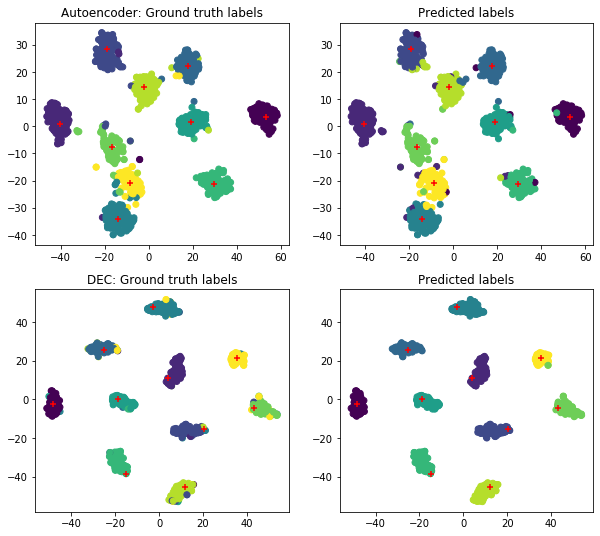

In [40]:
# Plot the ground truth data vs the predicted labels
cn = n_clusters
f = plt.figure(figsize=(10,9))

ax = f.add_subplot(221)
ax.title.set_text("Autoencoder: Ground truth labels")
ax.scatter(ae_z[cn:,0],ae_z[cn:,1],c=y[ix])
ax.scatter(ae_z[:cn,0],ae_z[:cn,1],c='r',marker='+')
# Predictions
ax = f.add_subplot(222)
ax.title.set_text("Predicted labels")
ax.scatter(ae_z[cn:,0],ae_z[cn:,1],c=ae_labels[ix])
ax.scatter(ae_z[:cn,0],ae_z[:cn,1],c='r',marker='+')

ax = f.add_subplot(223)
ax.title.set_text("DEC: Ground truth labels")
ax.scatter(dec_z[cn:,0],dec_z[cn:,1],c=y[ix])
ax.scatter(dec_z[:cn,0],dec_z[:cn,1],c='r',marker='+')
# Predictions
ax = f.add_subplot(224)
ax.title.set_text("Predicted labels")
ax.scatter(dec_z[cn:,0],dec_z[cn:,1],c=dec_labels[ix])
ax.scatter(dec_z[:cn,0],dec_z[:cn,1],c='r',marker='+')


It can be confirmed that DEC increases the intra-class similarity while decreasing the inter-class similarity which leads to a better quality for clustering.

As a final remark for the second part of this series, let's evaluate the accuracy and NMI measures when the Kmeans algorithm is directly applied to the input data. It can be confirmed that this algorithm is negatively affected by the curse of data dimentionality if the input data is directly used. 

In [44]:
# K-means with 10 clusters
km = KMeans(n_clusters=10)
km.fit(x)
# ae_idx stores the cluster membership of the data using autoencoder
idx = km.predict(x)
print(tabulate([['Kmeans', np.round(metrics.acc(y, idx),3),np.round(metrics.nmi(y, idx),3)]],  
              headers=['Method', 'Accuracy', 'NMI']))

Method      Accuracy    NMI
--------  ----------  -----
Kmeans         0.675  0.633


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
